# SCC.413 Applied Data Mining
# Week 18
# Sentiment Analysis

## Assessed Exercise

The task for this week is to build your own classifier for predicting the sentiment of Tweets. Tweets are provided from [SemEval-2016 Task 4 (Subtask A)](http://alt.qcri.org/semeval2016/task4/).

Using code and features from previous labs, build and evaluate a sentiment classifier, which classifies individual Tweets into `positive`, `negative` or `neutral`.

Include error analysis after you have evaluated your classifier.

Marks will be given as follows.
- 3 marks will be given for a well implemented and evaluated with at least 2 specialised feature sets (see below), and some error analysis.
- 2 marks will be given for a completed, and evaluated, basic classifier utilising features from previous labs, and error analysis.
- 1 mark will be given for a full attempt of a classifier.

This exercise must be demonstrated by Week 20's lab.

Specialised feature sets:
- Specific emoticons
- Just adjectives
- Words from a sentiment lexicon (e.g. see "Opinion Lexicon" from https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon).

Below are imports and helper functions from previous labs. You should edit and add to these.

In [ ]:
import ftfy
import nltk
import json

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Binarizer, StandardScaler

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re

from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split

For POS tagger, incase these haven't been previously downloaded.

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

A couple of methods for showing classifier results (from 1st classification lab):

In [ ]:
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))
    
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    
def confusion_matrix_percent_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    percents = cmdf.div(cmdf.sum(axis=1), axis=0)*100
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percents, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=100)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75, 100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

Our Document class and associated functions for processing text, similar to what you've seen in other labs.

In [ ]:
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.pos_fql = Counter()
        #
        self.ht_fql = Counter()
        #
        self.pos_list = [] #empty list for pos tags from running text.
        self.num_tokens = 0
        self.text = ""
        
    def extract_features_from_text(self, text):
        #
        hts = hashtag_re.findall(text)
        self.ht_fql.update([ht.lower() for ht in hts])
        #
        self.text += text
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        lower_tokens = [t.lower() for t in tokens]
        self.num_tokens += len(lower_tokens)
        self.tokens_fql.update(lower_tokens) #updating Counter counts items in list, adding to existing Counter items.
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)

In [ ]:
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): #no fitting necessary, although could use this to build a vocabulary for all documents, and then limit to set (e.g. top 1000).
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)

In [ ]:
def get_tokens_fql(document):
    return document.tokens_fql

def get_pos_fql(document):
    return document.pos_fql

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql


Here the Tweets are imported and put into a `Document` instance for each Tweet. This could be edited easily to use in CountVectorizer (as per week 17's lab), just return a list containing the tweet text, and a list containing the labels. All Tweets available from SemEval data are combined here, allowing for our own train/test split or cross-validation.

In [ ]:
def import_tweets_docs(file, label):
    metadata = {'label': label}
    with open(file) as f:
        tweets = f.readlines()
        for tweet in tweets:
            doc = Document(meta=metadata)
            doc.extract_features_from_text(tweet)
            yield doc

In [ ]:
corpus = []
corpus.extend(import_tweets_docs("sentiment/all/negative.txt", "negative"))
corpus.extend(import_tweets_docs("sentiment/all/positive.txt", "positive"))
corpus.extend(import_tweets_docs("sentiment/all/neutral.txt", "neutral"))

In [ ]:
y = [d.meta['label'] for d in corpus]
X = corpus

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

In [ ]:
len(y_train)

Accuracy:  0.5929919137466307
              precision    recall  f1-score   support

    negative       0.55      0.29      0.38       667
     neutral       0.55      0.80      0.65      2003
    positive       0.70      0.48      0.57      1782

    accuracy                           0.59      4452
   macro avg       0.60      0.52      0.53      4452
weighted avg       0.61      0.59      0.58      4452

[[ 195  396   76]
 [ 118 1593  292]
 [  39  891  852]]


,Tweet,Actual,Predicted
24,@realteddylong Raw and Smackdown. The authority is doing a lousy job. They're doing everything under the sun to keep Seth Rollins as champ\n,negative,positive
43,"Oh @TFIFridayLIVE your name may say ""Live"" but the god awful ""The Vamps"" we're far from live. Cut any bands who mime please !\n",negative,neutral
46,For I've always hated slavery since the day that I was born....and we're off to join the IRA and we're off tomorrow morn....\n,negative,neutral
52,John Kasich applied all the rote Republican dogma until he found out he couldn't govern that way. He may be the GOP voice in the wilderness.\n,negative,neutral
79,still so sad I'm not going to Ed Sheeran the 25th :////\n,negative,neutral
84,"Prochoice #UniteBlue Planned Parenthood's Foggy Evil: On Tuesday, the Center for Medical Pr... http://t.co/uBWmSrHgMo #PlannedParenthood\n",negative,neutral
89,"Just gonna say it: The lyrics in ""Bad Blood"" sound like they were written by a 7th grader. ""Done"" doesn't have two syllables, Taylor.\n",negative,neutral
96,@tbridis this why people don't believe anything Hillary say this person will soon take the 5th\n,negative,neutral
99,I'm probably jynxing it. But David Price has a no hitter going into the 4th\n,negative,neutral
100,Gay dominican man fucks pussy for the 1st time http://t.co/jtyIjKAQhe http://t.co/LA8NxTEAMT\n,negative,neutral


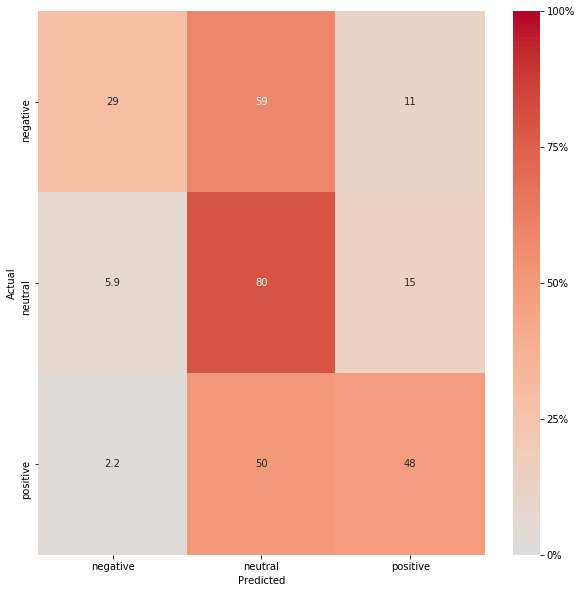

In [18]:
#Classifier 
from sklearn.feature_selection import SelectKBest, f_classif

class Document2:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.pos_fql = Counter()
        #
        self.emoji_fql = Counter()
        self.adj_fql = Counter()
        #
        self.pos_list = [] #empty list for pos tags from running text.
        self.num_tokens = 0
        self.text = ""
        
        
    def extract_features_from_text(self, text):
        self.text += text
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        lower_tokens = [t.lower() for t in tokens]
        self.num_tokens += len(lower_tokens)
        self.tokens_fql.update(lower_tokens) #updating Counter counts items in list, adding to existing Counter items.       
        pos_tagged = nltk.pos_tag(tokens)           
        pos = [tag[1] for tag in pos_tagged]
        
        ##Get the emoticons                
        r = r":\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)"
        EMOJI_PATTERN = re.compile(r)
        emojis = EMOJI_PATTERN.findall(text)
        self.emoji_fql.update(emojis)
        
        ##Get the adjectives
        adj_list = []
        for tag in pos_tagged:
            if tag[1] == ("JJ" or "JJR" or "JJS"):
                adj_list.append(tag[0])
        
        self.adj_fql.update(adj_list)
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            

def import_tweets_docs2(file, label):
    metadata = {'label': label}
    with open(file) as f:
        tweets = f.readlines()
        for tweet in tweets:
            doc = Document2(meta=metadata)
            doc.extract_features_from_text(tweet)
            yield doc            
            

def get_emoji_fql(document):    
    return document.emoji_fql


def get_adj_fql(document):    
    return document.adj_fql

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

positiveList = read_list("sentiment/opinion-lexicon-English/positive-words-utf8.txt")
negativeList = read_list("sentiment/opinion-lexicon-English/negative-words-utf8.txt")

def get_pos_fql(document):
    pos_fql = Counter({t: document.tokens_fql[t] for t in positiveList}) #dict comprehension, t: fql[t] is token: freq.
    return +pos_fql

def get_neg_fql(document):
    neg_fql = Counter({t: document.tokens_fql[t] for t in negativeList}) #dict comprehension, t: fql[t] is token: freq.
    return +neg_fql


corpus = []
corpus.extend(import_tweets_docs2("sentiment/all/negative.txt", "negative"))
corpus.extend(import_tweets_docs2("sentiment/all/positive.txt", "positive"))
corpus.extend(import_tweets_docs2("sentiment/all/neutral.txt", "neutral"))

y = [d.meta['label'] for d in corpus]
X = corpus
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)

#Error analysis
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [           
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)), # to be set by grid search.
                ('vectorizer', DictVectorizer()),
            ])),
            
            
            ('emoji', Pipeline([
                ('processor', DocumentProcessor(process_method = get_emoji_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('adj', Pipeline([
                ('processor', DocumentProcessor(process_method = get_adj_fql)),
                ('vectorizer', DictVectorizer()),
            ])),  
            
            ('pos', Pipeline([
                ('processor', DocumentProcessor(process_method = get_pos_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('neg', Pipeline([
                ('processor', DocumentProcessor(process_method = get_neg_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            
        ],
    )),
    ('selector', SelectKBest(score_func = f_classif)),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0, multi_class='ovr')),
])

param_grid={
    'union__word__processor__process_method': [get_emoji_fql, get_adj_fql, get_pos_fql, get_neg_fql],
    'selector__k': [50, 150, 400, 750],
}



search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )


search.fit(X_train, y_train)


predictions = search.predict(X_test)


X_test_texts = [x.text for x in X_test]
df = pd.DataFrame(list(zip(X_test_texts,y_test,predictions)), columns=["Tweet", "Actual", "Predicted"])
pd.options.display.max_colwidth = 300
df.head(10)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test,predictions), search.classes_)



df[df['Actual'].str.match("neutral") & ~df['Predicted'].str.match("neutral")]
df[df['Actual'].str.match("positive") & ~df['Predicted'].str.match("positive")]
df[df['Actual'].str.match("negative") & ~df['Predicted'].str.match("negative")]



For the assessment I implemented and evaluated with 2 specialised feature sets: Specific emoticons, adjectives and Words from a sentiment lexicon.
To achive this I created a new Document class, where I added a frequency list for emoticons and another one for adjectives. In extract_features_from_text I defined how can I get these values into their frequency list. I also read from the negative and positive file and create frequency list for them. Finally I defined the model and then train and visualize the result and error analysis with DataFrame and a confusion heatmap. 

To improve this we could maybe use another classifier, change the selector_k values or test_size, but did not test due to the huge amount of time that need to train.



